In [462]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

### In this version if a healthy individual(blue) is connected to an infected(red) there is a probability I that they
### will become infected. If an individual is red there is a probability R of becoming blue. We assume no immunity 
### after recovery, and also DONT assume that if an infected individual has only infected neighours they are 
### immune to recovery

In [463]:
N = 1000
k = 5 # on average the number of friends one has
p = 0.2 # probability of rewiring in the Wats-Strogatz algorithm

G = nx.connected_watts_strogatz_graph(N,k,p) # Small-world network

In [464]:
for j in range(N):
    G.nodes[j]['color'] = 'blue' # not infected

In [465]:
init_inf = 0.02 # proportion of infected people
threshold_up = int(0.2*N) # when the disease is successful
threshold_down = int(0.01*N) # when it dies off

init_distr = np.random.choice(N, int(round(N*init_inf)), replace=False) #Initial infected nodes

inf = int(round(N*init_inf))

In [466]:
for j in init_distr:
    G.nodes[j]['color'] = 'red' # infect

In [467]:
# Using standard SIR model

R = 0.01 #recovery probability
I = 0.1 #infection probability

nextstate = np.zeros(N)
inf_t =np.array([100*inf/N]) # infected at time t

In [468]:
while (threshold_down<inf) and (inf<threshold_up):
    for n, nbrs in G.adj.items():            #These two lines are a weird artefact for accesing neighbours in nx
        if G.nodes[n]['color'] == 'blue':
            if any([G.nodes[nbr]['color']=='red'] for nbr, eatr in nbrs.items() ):
                nextstate[n]=np.random.binomial(1,I)
            else:
                nextstate[n]=0
        else:                            #else it is infected and has probability of flipping and becoming succeptible again
            nextstate[n]=np.random.binomial(1,(1-R))
    inf = sum(nextstate)
    inf_t = np.append(inf_t,[100*inf/N])
    
    for j in range(N):
        if nextstate[j] == 0:
            G.nodes[j]['color'] = 'blue'
        else:
            G.nodes[j]['color'] = 'red'

The disease won and the infection level is 20.6%


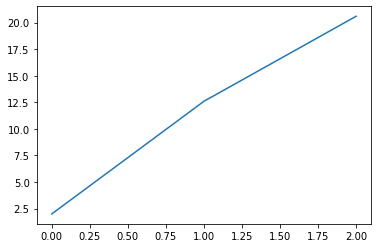

In [469]:
if inf<threshold_down:
    print("The disease was wiped out and the infection level is {}".format(round(100*inf/N,2)) )
if inf>threshold_up:
    print("The disease won and the infection level is {}%".format(round(100*inf/N,2)) )

plt.plot(inf_t)
plt.show()

This is expected since the recovery rate is much lower than the infection rate, there is essentially no way for the dissease to slow down.

We shall continue looking at the ones where we introduce immunity.

In [470]:
F = nx.connected_watts_strogatz_graph(N,k,p) 

for j in range(N):
    F.nodes[j]['color'] = 'blue' 
    
for j in init_distr:
    F.nodes[j]['color'] = 'red'
    
inf = int(round(N*init_inf))
inf_t_immune = np.array([100*inf/N])

In [471]:
while (threshold_down<inf<threshold_up):
    for n, nbrs in F.adj.items():            #These two lines are a weird artefact for accesing neighbours in nx
            if F.nodes[n]['color'] == 'blue':
                if any([F.nodes[nbr]['color']=='red'] for nbr, eatr in nbrs.items() ):
                    nextstate[n]=np.random.binomial(1,I)
                else:
                    nextstate[n]=0
            else:                            #else it is infected and has probability of flipping and becoming succeptible again
                nextstate[n]=int(np.random.binomial(1,R) + 1) #2 means immune now
    inf = list(nextstate).count(1)
    inf_t_immune = np.append([inf_t_immune],[100*inf/N])
    for j in range(N):
        if nextstate[j] == 0:
            F.nodes[j]['color'] = 'blue'
        elif nextstate[j] == 1:
            F.nodes[j]['color'] = 'red'
        else:
            F.nodes[j]['color'] = 'green' #immune
    

The disease won and the infection level is 27.1%


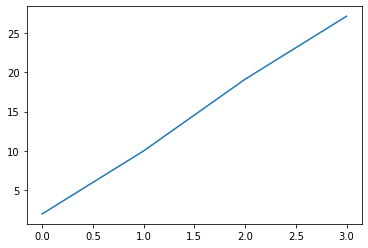

In [472]:
if inf<threshold_down:
    print("The disease was wiped out and the infection level is {}".format(round(100*inf/N,2)) )
if inf>threshold_up:
    print("The disease won and the infection level is {}%".format(round(100*inf/N,2)) )
    
plt.plot(inf_t_immune)
plt.show()

Now consider a model where the infection rate of an individual depends on the proportion od neighbours infected. Treat both, being red and being blue as infection states. This means, if an individual is red, then we look at the proportion of neighbours that are blue to calculate the switch rate. Similarly for blue individuals. Note, even if a node is blue and all its neighbours are red (or vice-versa) there is still a possibility of the individual to remain blue (This should reflect the fact that changing opinions is difficult). We do however want that if a blue individual is connected to only blue neighbours, the probability of becomming radicalized is 0. We shall assume first that the infection rate of red (radical ideas) is higher than blue, so that it makes sense to talk about an idea to be successful, otherwise it is obvious that blue would win if the starting percentage of red is around 3% as reffered in the paper.

We consider no Immunity.

In [473]:
H = nx.connected_watts_strogatz_graph(N,k,p) 

for j in range(N):
    H.nodes[j]['color'] = 'blue' 
    
for j in init_distr:
    H.nodes[j]['color'] = 'red'
    
inf = int(round(N*init_inf))
inf_t = np.array([100*inf/N])

I = 0.4 #at maximum red neighbours this is the flipping rate for blue
R = 0.35 #at maximum blue neighbours this is the flipping rate for red

In [474]:
while (threshold_down<inf<threshold_up):
    for n, nbrs in H.adj.items():           #These two lines are a weird artefact for accesing neighbours in nx
        countr = 0                      #count red neighbours
        for nbr, eatr in nbrs.items():
            if H.nodes[nbr]['color']=='red':
                countr = countr + 1
        if H.nodes[n]['color'] == 'blue':
            nextstate[n]=np.random.binomial(1,I*countr/len(nbrs))
        else:                            #else it is infected and has probability of flipping and becoming succeptible again
            nextstate[n]=np.random.binomial(1,(1-R*(1-(countr/len(nbrs))))) 
    inf = list(nextstate).count(1)
    inf_t = np.append([inf_t],[100*inf/N])
    for j in range(N):
        if nextstate[j] == 0:
            H.nodes[j]['color'] = 'blue'
        elif nextstate[j] == 1:
            H.nodes[j]['color'] = 'red'
    

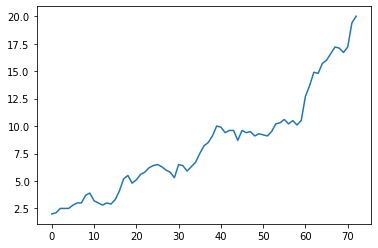

In [475]:
if inf<threshold_down:
    print("The disease was wiped out and the infection level is {}".format(round(100*inf/N,2)) )
if inf>threshold_up:
    print("The disease won and the infection level is {}%".format(round(100*inf/N,2)) )
    
plt.plot(inf_t)
plt.show()